In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time

DATA_PATH = "D:/DNMCS/profile_semantic_trafo_final.txt"
data = pd.read_table(DATA_PATH, delim_whitespace=True)

In [9]:
# Variable node sizes
# Variable colors for nodes
# Variable colors for edges
# Highlight

def static_node_link(path, df, start_node, end_node, layout,
                     directed=True, edge_weight="None", node_size="", color="None",
                     color_nodes=True, cmap="jet", with_labels=False):
    """
    ~~~ ARGS ~~~
    path         str           folder to store images in
    df           pd.DataFrame  data frame
    start_node   str           Name of column for start node (U)
    end_node     str           Name of column for end node (V)
    layout       str           Kind of node link diagram (Circular or Fruchterman-Reingold)
    directed     function      Determines whether lines have arrows or not
    edge_weight  str           Optional: Column for associated weights
    node_size    str           Optional: Column for node sizes (Will be summed over start nodes (Dir) or nodes involved (NDir))
    **kwargs     -             Additional arguments to be passed into nx.draw()
    """
    
    plt.figure(figsize=(9.74,9.74))
    plt.axis("off")
    
    # GROUPS BY START AND END NODE THEN SUMS WEIGHTS
    df = df.groupby([start_node, end_node], as_index=False).sum()
    
    # CREATE EMPTY CANVAS
    canvas_dict = {True: nx.DiGraph, False: nx.Graph}
    G = canvas_dict[directed]()
    
    # ADD NODES TO PLOT
    all_nodes = sorted(list(set(df[start_node].append(df[end_node]))))
    for node in all_nodes:
        G.add_node(node)
    
    # ADD EDGES TO PLOT
    df.apply(lambda row: G.add_edge(row[start_node], row[end_node]), axis=1)
    
    # GET NORMALIZED NODE COLORS
    cmap_dict = {"jet": plt.cm.jet, "terrain": plt.cm.terrain, "plasma": plt.cm.plasma, "viridis": plt.cm.viridis}
    node_colors = df.groupby(start_node)[[color]].sum()\
                   .reindex(index=all_nodes)\
                   .iloc[:,0].values
    node_colors[np.isnan(node_colors)] = np.nanmin(node_colors)
    node_colors = list(node_colors / max(node_colors))
    
     # GET NORMALIZED NODE SIZES
    if node_size == "":
        degrees = nx.degree(G)
        node_sizes = np.array([d[1] for d in G.degree])
    else:
        node_sizes = df.groupby(start_node)[[node_size]].sum()\
                       .reindex(index=all_nodes)\
                       .iloc[:,0].values
        node_sizes[np.isnan(node_sizes)] = np.nanmin(node_sizes)
    
    node_sizes = list(390 * node_sizes / max(node_sizes) + 10)
    #ode_order = sorted(range(len(node_sizes)), key=node_sizes.__getitem__)
    
    # GET POSITIONS OF NODES
    pos_layout_dict = {"Fruchterman-Reingold": (nx.spring_layout(G)),
                       "Circular": (nx.circular_layout(G))}
    pos = pos_layout_dict[layout]
    
    edge_widths = df[edge_weight]
    edge_colors = list(edge_widths / max(edge_widths))[1:]
    edge_widths = list(4* edge_widths / max(edge_widths) + 1)
    
    # DRAW NETWORK
    nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), width=edge_widths, alpha=0.7,
                           edge_color=edge_colors,
                           cmap=cmap_dict[cmap], edge_vmax=1, edge_vmin=0)
    nx.draw_networkx_nodes(G, pos=pos,
                           node_list=all_nodes, node_size=node_sizes,
                           node_color=node_colors,
                           cmap=cmap_dict[cmap], vmax=1, vmin=0, with_labels=with_labels)
    
    plt.savefig(path + str(int(time.time())) + ".png")

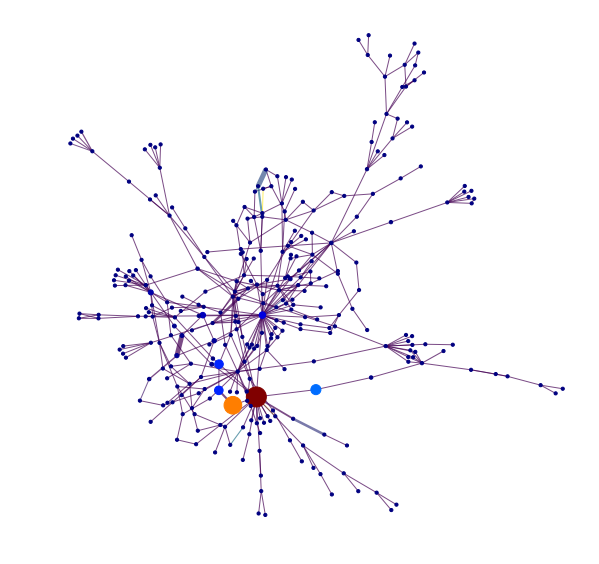

In [10]:
static_node_link("graphs/", data.head(1000), node_size="weight", directed=False, cmap="jet", start_node="start", end_node="target", edge_weight="weight", color="weight", layout="Fruchterman-Reingold")